# AIComprehendChats

**Contexto empresarial**. Diariamente miles de clientes se comunican con el chatbot de la empresa para recibir atención post venta.
El contenido de cada sesión de chat se guarda en distintas tablas de BigQuery a las cuales accedemos para hacer análisis de los datos.
AL finalizar la atención, el bot invita al usuario a responder una encuesta sobre la atención recibida.
Estas calificaciones nos permiten tomar acciones posteriores para mejorar los procesos más dolorosos para el cliente.
Este proyecto propone cuantificar la satisfacción del cliente derivada de las interacciones no calificadas para entender mejor los motivos donde el cliente no llegó al resultado esperado y así poder tomar decisiones comerciales, incluso en tiempo real para gestión de crisis.

**Problema empresarial.** el proposito de este proyecto consiste en crear modelos que identifiquen el sentimiento (positivo o negativo) de cada una de estas interacciones no calificadas.

**Desafíos.** Leer y analizar los datos del texto de entrada y las variables de respuesta correspondientes (calificaciones).
Realizar un preprocesamiento básico para preparar los datos para el modelado.
Aplicar diversas técnicas de NLP para caracterizar el texto de las reseñas.
Construir modelos de aprendizaje automático para clasificar el texto según su opinión, ya sea positiva o negativa (1 o 0).

## Importación de librerías

In [ ]:
!pip install numpy==1.25.2 # intsalacion de una versión especifica de Numpy para resolver a posteriori problemas de compatibilidad con librería gensim

In [ ]:
# General packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import histplot

# NLP packages
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk import word_tokenize
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 14, 6

## Carga de datos

Trabajaremos con un archivo .csv que contiene el texto de las conversaciones de clientes que posteriormente han calificado la atención recibida.

Para garantizar la privacidad y seguridad de los datos sensibles de los clientes durante el análisis de chats, se implementó una estrategia de anonimización basada en el enmascaramiento mediante expresiones regulares en consultas SQL. Este proceso involucró la identificación y sustitución de patrones de información sensible, como números de teléfono, correos electrónicos y nombres de empresas, por marcadores de anonimización ("***") utilizando la función `REGEXP_REPLACE`. La anonimización, realizada dentro de una subconsulta `WITH` antes de operaciones de unión y agregación, busca cumplir con regulaciones como el **Reglamento General de Protección de Datos**, fortalecer la confianza del cliente, prevenir riesgos y actuar de manera ética.

De esta forma, los datos incluyen los siguientes atributos:
* **session_id:** identificador de la conversación existente dentro del chat.
* *session_creation_date:* marca tempostal de inicio de la sesión.
* **realizarEncuesta:** variable que representa si el cliente accede a responder la encuesta.
* **csat:** nota sobre la atención recibida. Valor 1 representa el menor grado de satisfacción y 5 el mayor grado de satisfacción.
* **solved:** respuesta booleana sobre la la reolución satisfactoria del motivo del contacto.
* **nps:** nota sobre la satisfacción general sobre el servicio contratado. Valor 1 representa el menor grado de satisfacción y 10 el mayor grado de satisfacción.
* **review:** comentarioque hace el usuario sobre su experiencia con el chat de atención.
* **sentiment_label:** a partir de las notas de atención, se agrupan como positivas las de valor 4 y 5 y negativas las de valor 1 y 2.(más adelante refinaremos esta variable para usarla como target).
* **user_message:** contenido de los mensajes enviados por el usuario.
* **bot_message:** contenido de los mensajes enviados por chatbot.
* **operator_message:** contenido de los mensajes enviados por asistente humano.

In [ ]:
%%time
df = pd.read_csv("https://media.githubusercontent.com/media/vierbo/Data-Science/refs/heads/main/AIComprehendChats/bm_messages_aggregated_AND_encuesta.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269306 entries, 0 to 269305
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   session_id             269306 non-null  object 
 1   session_creation_date  269306 non-null  object 
 2   realizarEncuesta       216834 non-null  object 
 3   csat                   269306 non-null  int64  
 4   solved                 269268 non-null  object 
 5   nps                    251160 non-null  float64
 6   review                 216744 non-null  object 
 7   sentiment_label        269306 non-null  int64  
 8   user_message           250935 non-null  object 
 9   bot_message            262974 non-null  object 
 10  operator_message       224528 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 22.6+ MB
CPU times: user 17.2 s, sys: 4.63 s, total: 21.8 s
Wall time: 57 s


## Data Wrangling

Antes de comenzar a analizar los datos, se procesarán para eliminar filas y columnas que no sean relevantes, manipulación de registros nulos, ajustar el formato de los datos y crear nuevos campos necesarios para el modelo.

In [ ]:
# Imputar NaN en NPS con 1 si CSAT es "detractor", con 9 si CSAT "promoter", o 7 si es "neutral"
df['nps'] = df['nps'].fillna(
    df.apply(lambda row: 1 if pd.isna(row['nps']) and row['csat'] < 3 else row['nps'], axis=1)
)
df['nps'] = df['nps'].fillna(
    df.apply(lambda row: 9 if pd.isna(row['nps']) and row['csat'] > 3 else row['nps'], axis=1)
)
df['nps'] = df['nps'].fillna(
    df.apply(lambda row: 7 if pd.isna(row['nps']) and row['csat'] == 3 else row['nps'], axis=1)
)

In [ ]:
# Imputar NaN en solved con False si CSAT es "neutral" o "detractor", con True si CSAT "promoter".
df['solved'] = df['solved'].fillna(
    df.apply(lambda row: False if pd.isna(row['solved']) and row['csat'] <= 3 else row['solved'], axis=1)
)
df['solved'] = df['solved'].fillna(
    df.apply(lambda row: True if pd.isna(row['solved']) and row['csat'] > 3 else row['solved'], axis=1)
)

<ipython-input-5-1578add9890b>:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['solved'] = df['solved'].fillna(


In [ ]:
# Ajuste de campos al formato deseado
df['nps'] = pd.to_numeric(df['nps'], errors='coerce').fillna(0).astype(int)
df['review'] = df['review'].astype(str)
df['user_message'] = df['user_message'].astype(str)
df['bot_message'] = df['bot_message'].astype(str)
df['operator_message'] = df['operator_message'].astype(str)
df['session_creation_date'] = pd.to_datetime(df['session_creation_date'],  format="%Y-%m-%d")
df['solved'] = df['solved'].replace({True: 1, False: 0}).fillna(0).astype(int)

<ipython-input-6-d7cf950e7f2e>:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['solved'] = df['solved'].replace({True: 1, False: 0}).fillna(0).astype(int)


In [ ]:
# Eliminar las los campos irrelevantes
if 'realizarEncuesta' in df.columns:
  df = df.drop('realizarEncuesta', axis=1)
if 'session_id' in df.columns:
  df = df.drop('session_id', axis=1)
if 'sentiment_label' in df.columns:
  df = df.drop('sentiment_label', axis=1)

In [ ]:
# Elimimación de registros sin nota de atención o contenido en mensajes de usuario o bot.
df = df[(df['csat'].notna()) & (df['user_message'].notna()) & (df['user_message'] != '') &(df['bot_message'].notna())& (df['bot_message'] != '')]
df.reset_index(drop=True, inplace=True)

Analizando el contenido de los mensajes de usuario, encontramos muchas sesiones "vacías" creadas a partir un mensaje de saludo o respuesta sobre la sesión anterior, pero que luego no continúa. Por esto, vamos a conservar solo las sesiones donde el usuario escribió al menos tres palabras.

In [ ]:
df['user_message_words']= df["user_message"].apply(lambda x: len(str(x).split(" ")) if not isinstance(x, float) or not pd.isna(x) else 0)
##df.head().sort_values(by='user_message_words')

In [ ]:
# Eliminar filas donde los mensajes del usuario tengan menos de 2 palabras
df = df[df['user_message_words'] > 3]
df.reset_index(drop=True, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215490 entries, 0 to 215489
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   session_creation_date  215490 non-null  datetime64[ns]
 1   csat                   215490 non-null  int64         
 2   solved                 215490 non-null  int64         
 3   nps                    215490 non-null  int64         
 4   review                 215490 non-null  object        
 5   user_message           215490 non-null  object        
 6   bot_message            215490 non-null  object        
 7   operator_message       215490 non-null  object        
 8   user_message_words     215490 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 14.8+ MB


## Exploratory Data Analysis

Hacemos algunos análisis generales de los datos disponibles para entenderlos mejor.

### CSAT

Text(0.5, 1.0, 'Distribución de nota de atención (CSAT)')

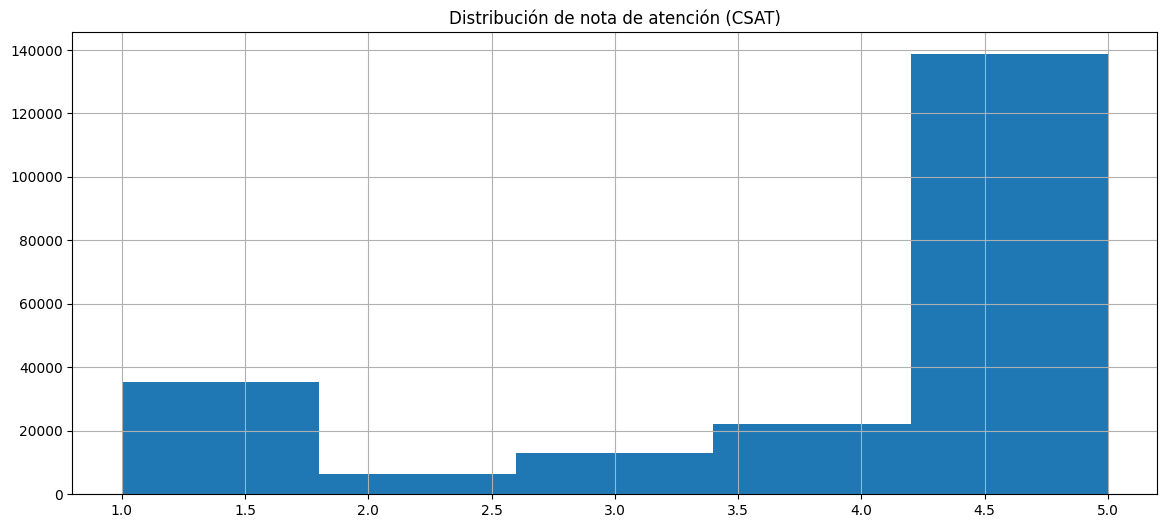

In [ ]:
df['csat'].value_counts().sort_index(ascending=True)
df['csat'].hist(bins=5)
plt.title('Distribución de nota de atención (CSAT)')

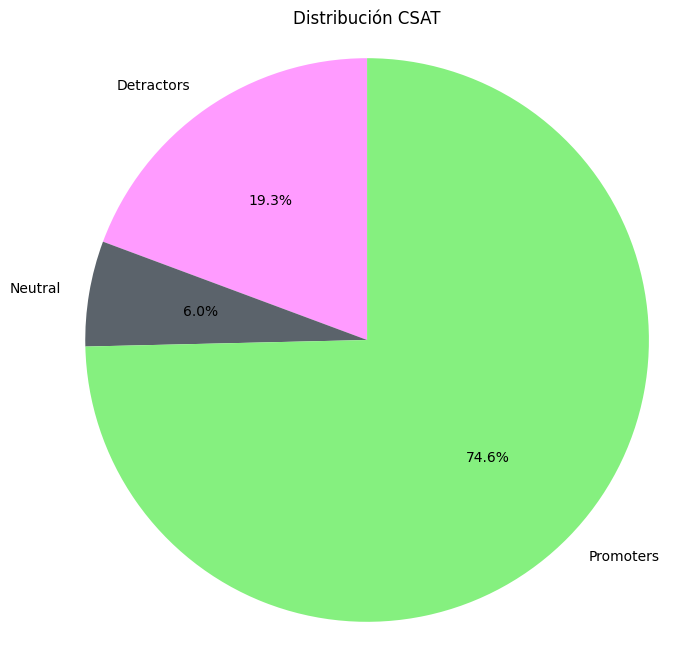

In [ ]:
# Calcula la cantidad de detractores, neutrales y promotores
detractors = df[df['csat'] < 3]['csat'].count()
neutrals = df[df['csat'] == 3]['csat'].count()
promoters = df[df['csat'] > 3]['csat'].count()

# Crea los datos para el gráfico circular
labels = ['Detractors', 'Neutral', 'Promoters']
sizes = [detractors, neutrals, promoters]
colors = ['#FF9BFF', '#5B636B', '#85F07F']

# Crea el gráfico circular
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Distribución CSAT')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Ajusta la estética de Seaborn (opcional)
sns.set_style("whitegrid")  # o "darkgrid", "white", "dark", "ticks"
sns.set_palette(colors) # Usa los mismos colores de antes

plt.show()


Text(0.5, 1.0, 'evolución de CSAT')

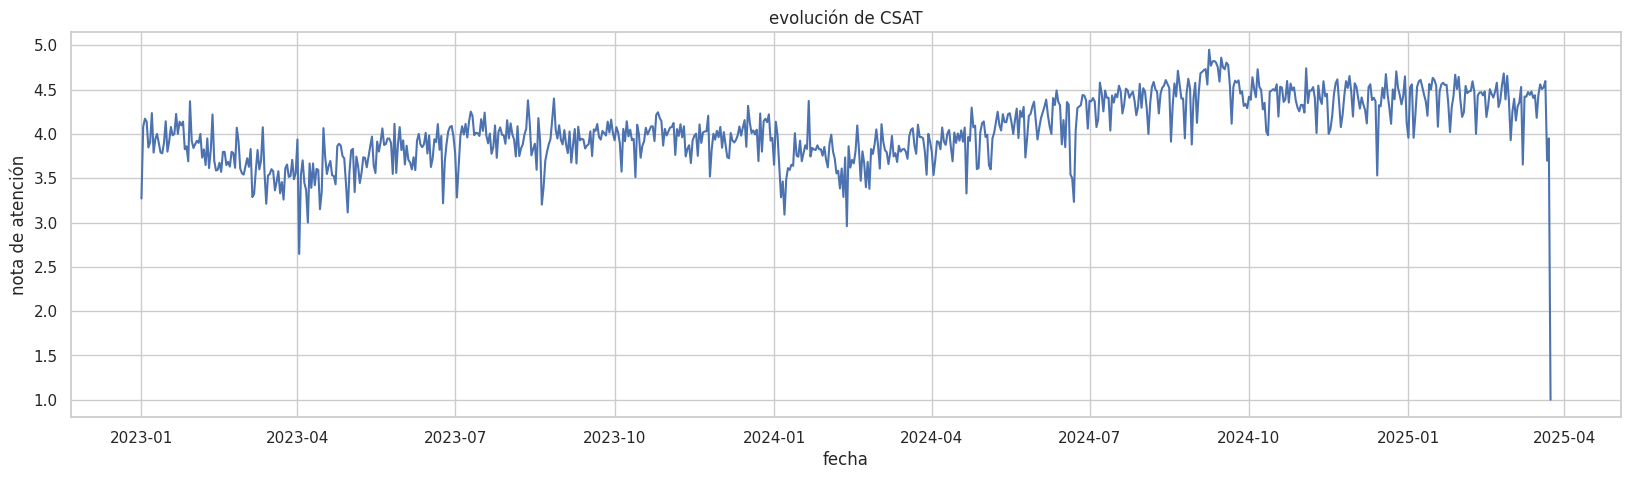

In [ ]:
plt.figure(figsize=(20, 5))
sns.set(style="whitegrid")

# group by the song's popularity and then get the mean energy
x = df.groupby("session_creation_date")["csat"].mean()
axis = sns.lineplot(x=x.index, y=x)

axis.set_ylabel('nota de atención')
axis.set_xlabel('fecha')
axis.set_title("evolución de CSAT")

### NPS

Text(0.5, 1.0, 'Distribución de nota de servicio (NPS)')

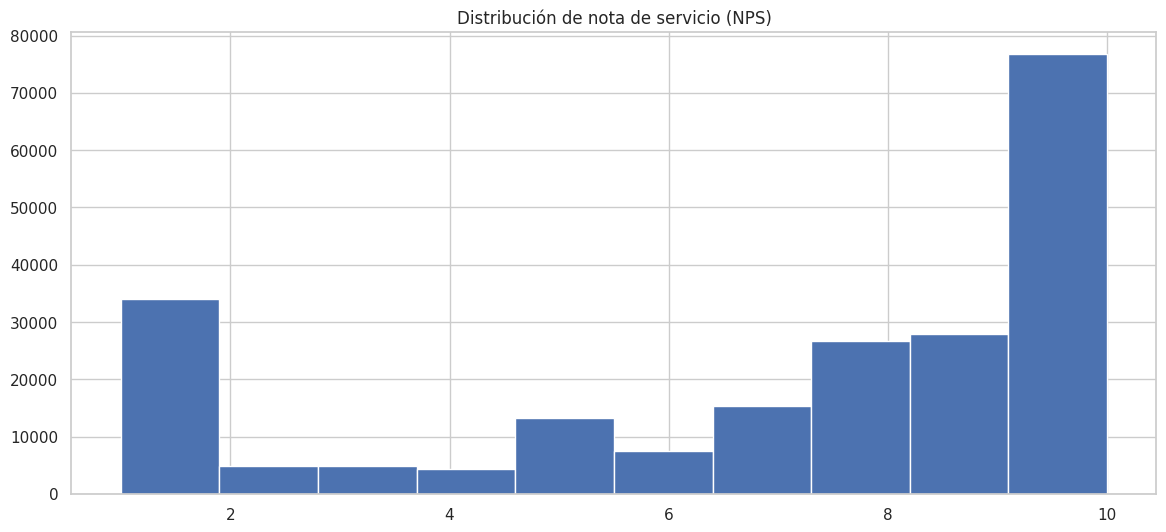

In [ ]:
df['nps'].value_counts().sort_index(ascending=True)
df['nps'].hist(bins=10)
plt.title('Distribución de nota de servicio (NPS)')

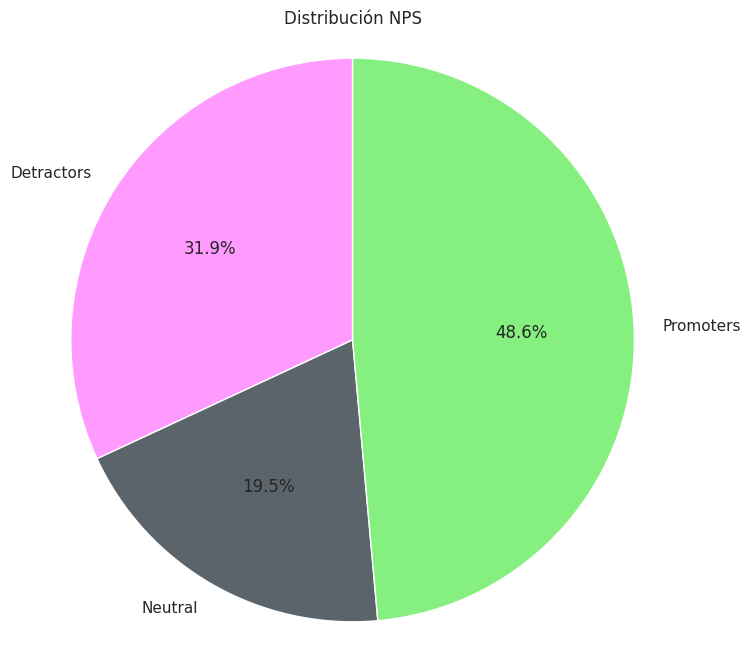

In [ ]:
# Calcula la cantidad de detractores, neutrales y promotores
detractors = df[df['nps'] <= 6]['nps'].count()
neutrals = df[df['nps'].isin([7, 8])]['csat'].count()
promoters = df[df['nps'] >= 9]['csat'].count()

# Crea los datos para el gráfico circular
labels = ['Detractors', 'Neutral', 'Promoters']
sizes = [detractors, neutrals, promoters]
colors = ['#FF9BFF', '#5B636B', '#85F07F']

# Crea el gráfico circular
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Distribución NPS')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Ajusta la estética de Seaborn (opcional)
sns.set_style("whitegrid")  # o "darkgrid", "white", "dark", "ticks"
sns.set_palette(colors) # Usa los mismos colores de antes
plt.show()

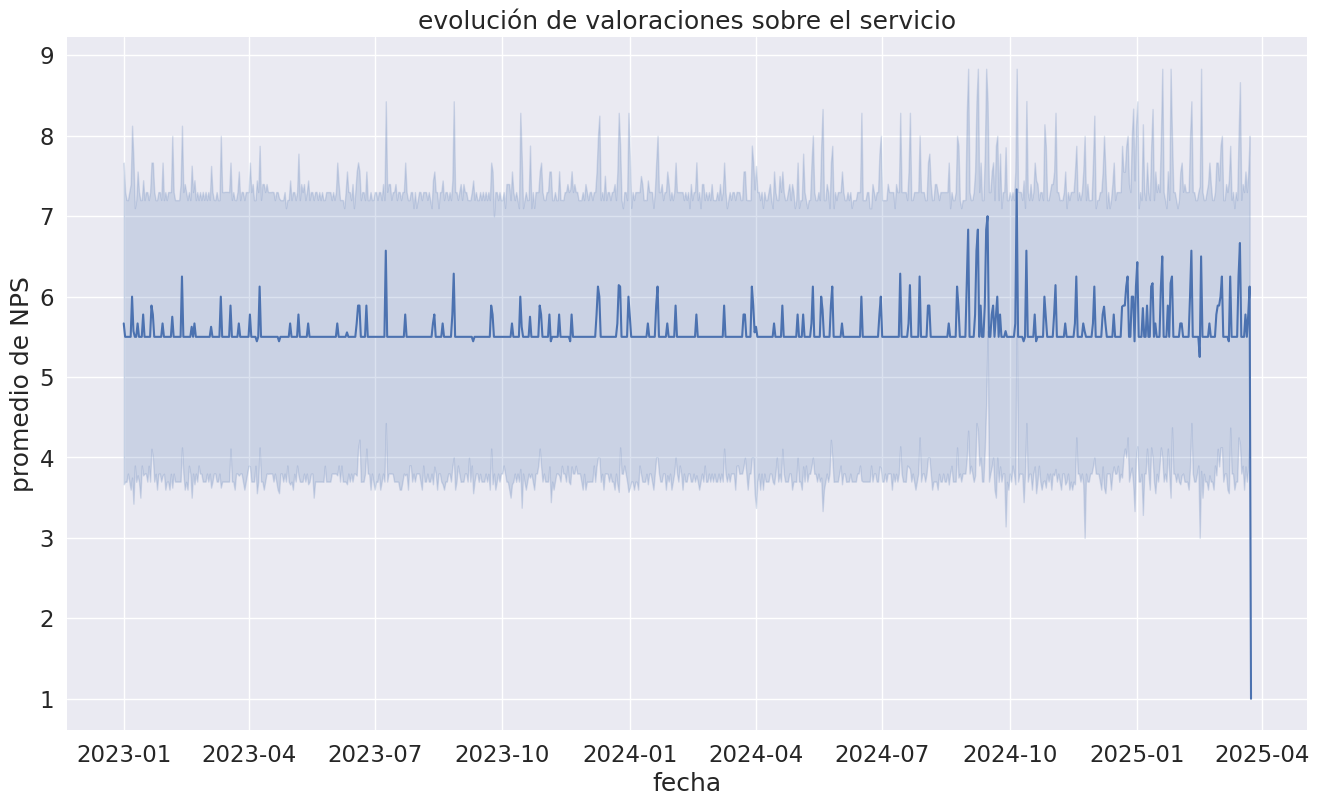

In [ ]:
data = df[['session_creation_date','nps']].drop_duplicates().copy()
sns.set(rc={'figure.figsize':(16,9)})
sns.set_style("whitegrid")
sns.set(font_scale = 1.5)
sns.lineplot(data,x='session_creation_date',y='nps')
plt.xlabel('fecha')
plt.ylabel('promedio de NPS')
plt.title('evolución de valoraciones sobre el servicio')
# Obtener el objeto de los ejes actual
ax = plt.gca()

# Quitar las espinas (bordes) del gráfico using the Axes object
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Quitar las marcas de los ejes
plt.tick_params(top=False, bottom=False, left=False, right=False)

### Tamaño del chat

Text(0, 0.5, 'cantidad de sesiones')

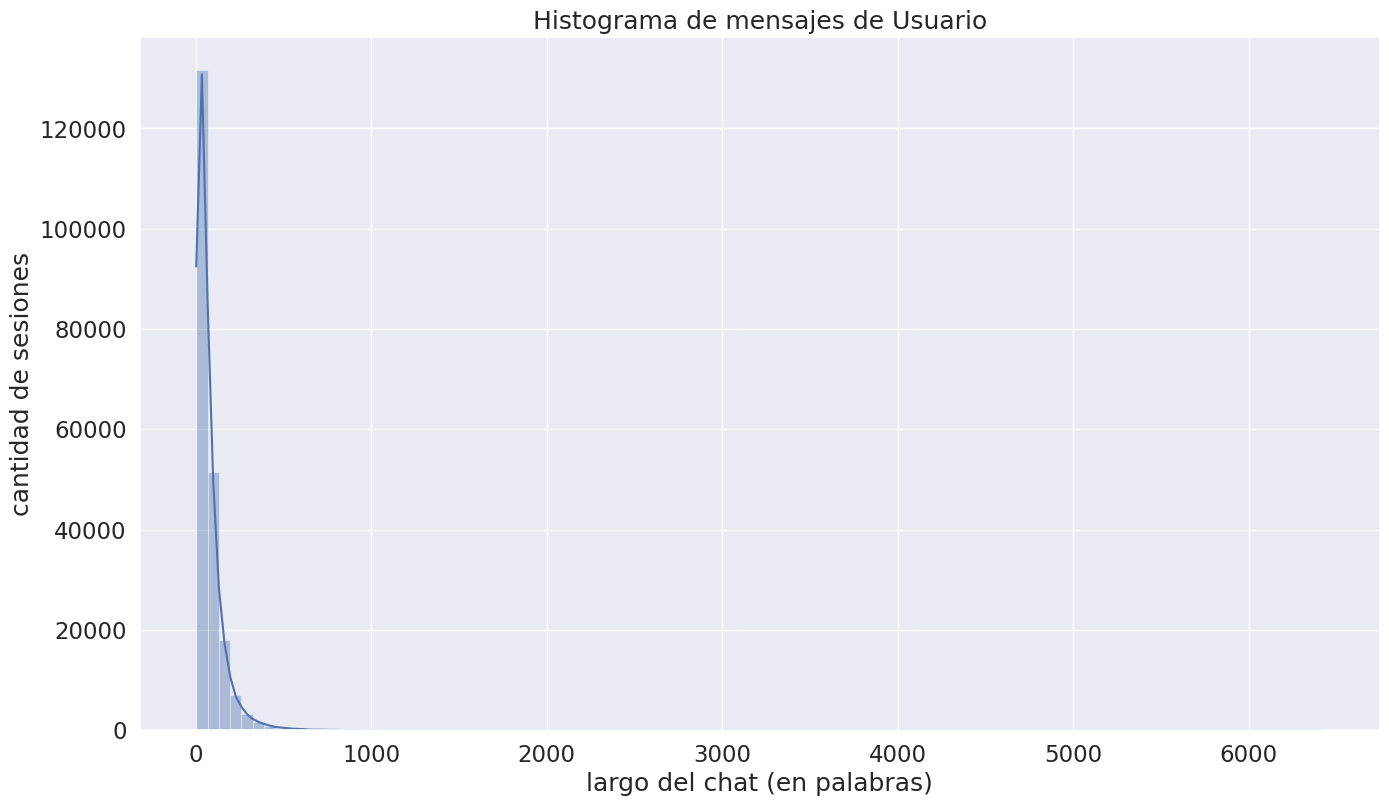

In [ ]:
#Histograma
words_per_review = df["user_message"].apply(lambda x: len(str(x).split(" ")) if not isinstance(x, float) or not pd.isna(x) else 0)
histplot(words_per_review, kde=True, bins=100,alpha=.4, edgecolor=(1, 1, 1, .4))
plt.title('Histograma de mensajes de Usuario')
plt.xlabel('largo del chat (en palabras)')
plt.ylabel('cantidad de sesiones')

Text(0, 0.5, 'cantidad de sesiones')

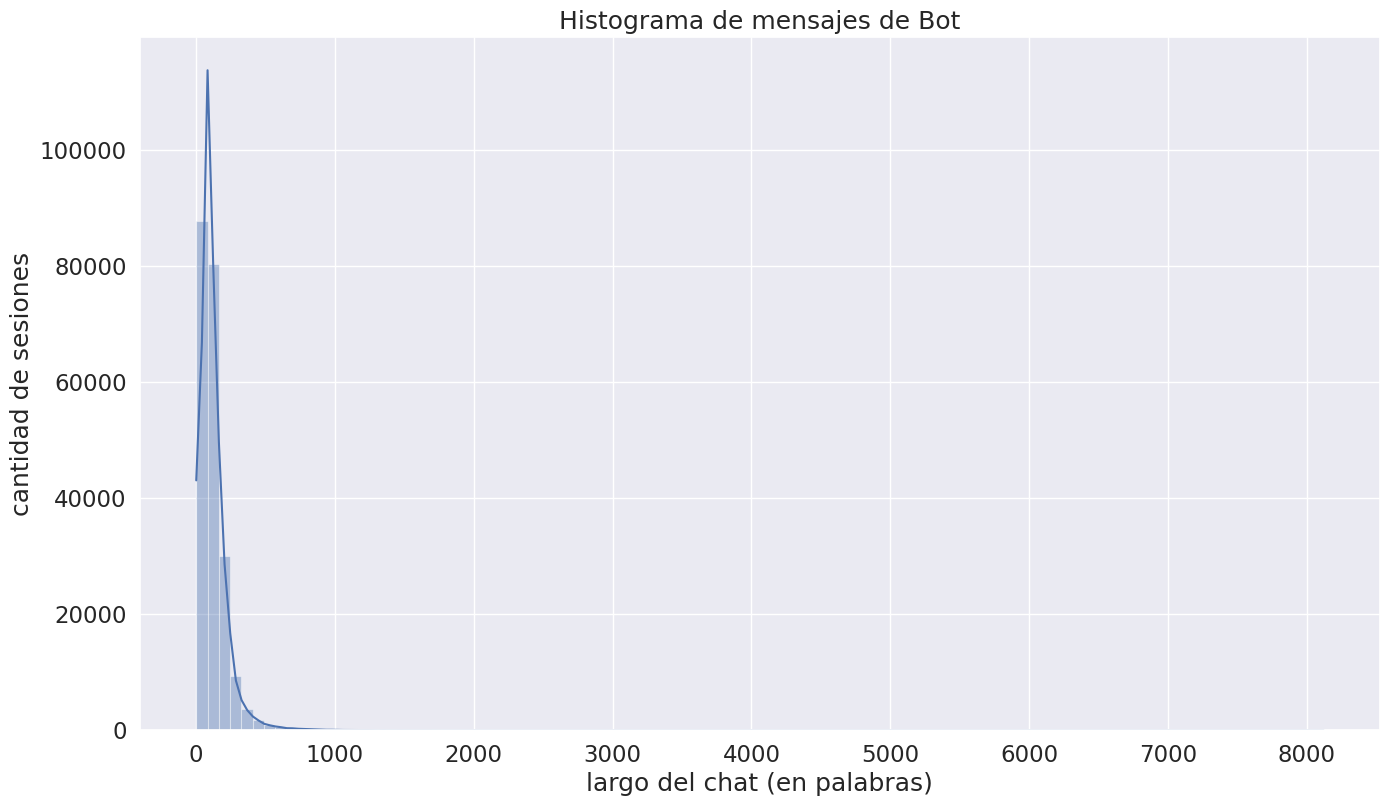

In [ ]:
#Histograma
words_per_review = df["bot_message"].apply(lambda x: len(str(x).split(" ")) if not isinstance(x, float) or not pd.isna(x) else 0)
histplot(words_per_review, kde=True, bins=100,alpha=.4, edgecolor=(1, 1, 1, .4))
plt.title('Histograma de mensajes de Bot')
plt.xlabel('largo del chat (en palabras)')
plt.ylabel('cantidad de sesiones')

In [ ]:
print('Promedio de palabras:', words_per_review.mean())
print('Sesgo/Asimetría:', words_per_review.skew())

Promedio de palabras: 120.42787600352685
Sesgo/Asimetría: 11.823540613474716


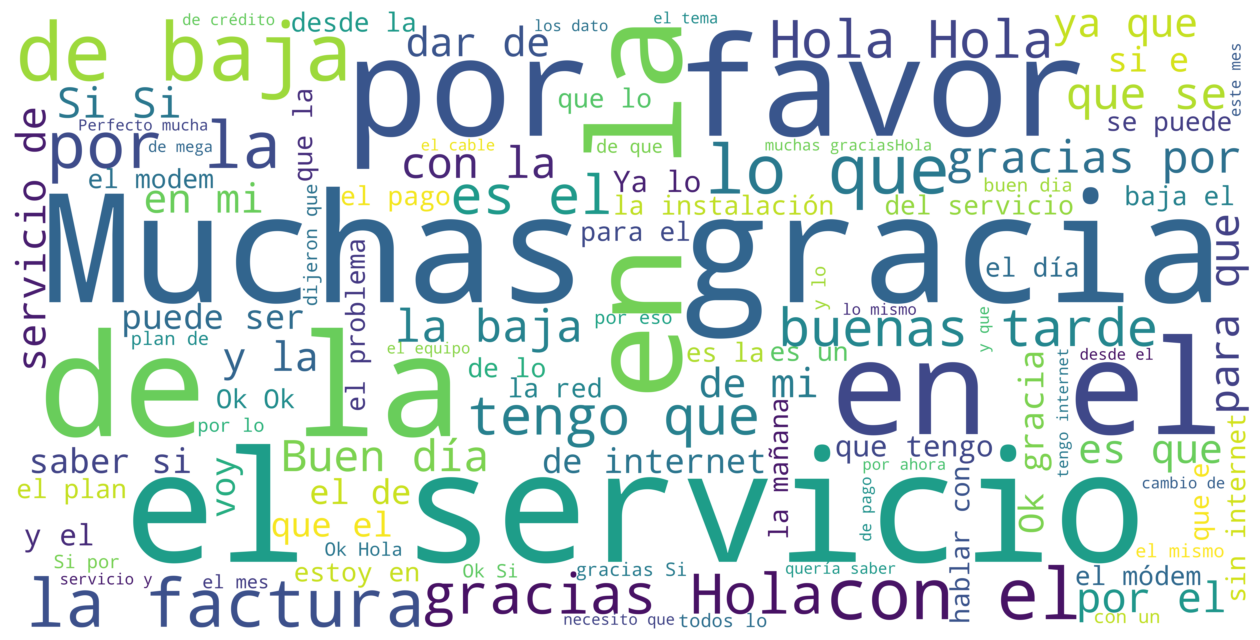

CPU times: user 59.9 s, sys: 3.54 s, total: 1min 3s
Wall time: 1min 3s


In [ ]:
%%time
word_cloud_text = ''.join(df['user_message'])

wordcloud = WordCloud(max_font_size=100, # Maximum font size for the largest word
                      max_words=100, # The maximum number of words
                      background_color="white", # Background color for the word cloud image
                      scale = 10, # Scaling between computation and drawing
                      width=800, # Width of the canvas
                      height=400 # Height of the canvas
                     ).generate(word_cloud_text)

plt.figure()
plt.imshow(wordcloud,
           interpolation="bilinear") # to make the displayed image appear more smoothly
plt.axis("off")
plt.show()

Como vemos, la gran mayoria se palabras más frecuentes no tienen ningún valor de análisis, es decir, podemos considerarlas como palabras vacías. Por esto, vamos a aplicar algunas técnicas de pre porcesamiento antes de llegar al modelo de NLP.

## Pre-processing

 El preprocesamiento y la normalización del texto son cruciales antes de construir un modelo de NLP adecuado.

### Normalización de calificaciones de atención

Para el análisis de sentimiento, convertiremos todas las calificaciones en valores binarios siguiendo la siguiente regla:


*   Las calificaciones de 4 o 5 se asignarán a 1 y se relacionarán con reseñas positivas.
*   Las calificaciones de 1 o 2 se asignarán a 0 y se relacionarán con reseñas negativas.
*   Las calificaciones de 3 se eliminarán, ya que representan reseñas neutrales.

In [ ]:
# Mapeo de las calificaciones
df['Sentiment_rating'] = np.where(df.csat > 3,1,0)

## Eliminación de reseñas neutrales
df = df[df.csat != 3]
df.reset_index(drop=True, inplace=True)

# Impresión de los recuentos de cada clase
df['Sentiment_rating'].value_counts()

,count
Sentiment_rating,
1,160818
0,41650


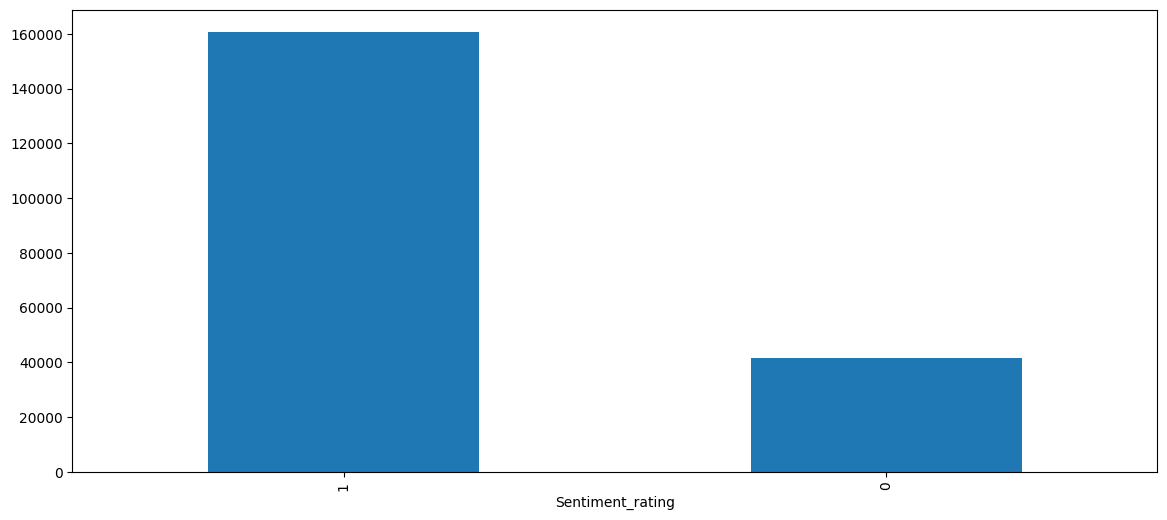

In [ ]:
df.Sentiment_rating.value_counts().plot.bar()
plt.show()

### Undersampling

Existe un desequilibrio de clases muy grande de casi 4:1, por lo tanto aplicaremos técnicas de **undersampling**, eliminnando muestras de la clase mayoritaria para igualar el número de muestras en todas las clases.

In [ ]:
from sklearn.utils import resample

 # Separar las clases
df_majority = df[df.Sentiment_rating == 1]  # Clase mayoritaria (ejemplo)
df_minority = df[df.Sentiment_rating == 0]  # Clase minoritaria (ejemplo)

 # Submuestrear la clase mayoritaria
df_majority_downsampled = resample(df_majority,
                                   replace=False,    # sample without replacement
                                   n_samples=len(df_minority),  # to match minority class
                                   random_state=123) # reproducible results

 # Combinar la clase minoritaria con la clase mayoritaria submuestreada
df = pd.concat([df_majority_downsampled, df_minority])
df.reset_index(drop=True, inplace=True)

 # Verificar el balance
print(df['Sentiment_rating'].value_counts())

Sentiment_rating
1    41650
0    41650
Name: count, dtype: int64


### Eliminar información personal con NER

La limpieza de datos sensibles con **Named Entity Recognition** (NER) es crucial para anonimizar información personal identificable (PII) en textos. Esto permite analizar y utilizar los datos sin comprometer la privacidad de los individuos y cumpliendo con las regulaciones de protección de datos.

Realizamos este proceso de anonimización para proteger la privacidad de los usuarios y cumplir con las regulaciones de protección de datos. Al eliminar la información personal de los datos de texto, como nombres, ubicaciones y organizaciones, nos aseguramos de que los datos puedan ser utilizados para análisis y modelado de lenguaje natural sin comprometer la confidencialidad de los individuos involucrados. Esto es fundamental para construir sistemas de inteligencia artificial responsables y éticos.

In [ ]:
!python -m spacy download es_core_news_sm
import spacy
import re
nlp = spacy.load("es_core_news_sm") # cargar modelo de lenguaje español

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 26.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Anonimiza la información personal en un texto utilizando NER.
def anonimizar_texto(texto):
    doc = nlp(texto)
    nuevas_palabras = []
    for ent in doc.ents:
        if ent.label_ in ["PER", "ORG", "LOC"]: # Identificar entidades PERSONA, ORGANIZACION, LOCATION
            # Escape special characters in ent.text to treat them literally
            texto = re.sub(re.escape(ent.text), "***", texto) # reemplaza la entidad con "[ANONIMIZADO]"
    return texto

In [ ]:
# Anonimiza una columna de texto en un DataFrame.
def anonimizar_columna(df, columna):
    df[columna + '_anonimizado'] = df[columna].apply(anonimizar_texto)
    return df

In [ ]:
# Ejemplo de uso:
texto_ejemplo = "Juan Pérez trabaja en Google en Madrid."
texto_anonimizado = anonimizar_texto(texto_ejemplo)
print(texto_anonimizado)

*** trabaja en *** en ***.


In [ ]:
%%time
df = anonimizar_columna(df, 'user_message')

CPU times: user 32min, sys: 3.99 s, total: 32min 4s
Wall time: 32min 18s


In [ ]:
df[['user_message','user_message_anonimizado']].head() # muestra las primeras lineas del texto anonimizado

,user_message,user_message_anonimizado
0,"Hola\n***\n***\nBuenos días, Jorgelina\nEstoy ...","***\n***\n***\n*** días, *** experimentando co..."
1,Buenas tardes\n***\n***\nBuenas tardes\nNecesi...,Buenas tardes\n***\n***\nBuenas tardes\nNecesi...
2,Hola Agustina\nEse es viejo..... Pedí que lo c...,*** es viejo..... *** que lo cambien porque no...
3,Hola\nMónica Loru\n***\nAv corrientes ***\nNin...,***\n***\nAv corrientes ***\nNinguno\nSi\nMóni...
4,"Hola, por algun motivo internet se desconecta ...","***, por algun motivo internet se desconecta d..."


In [ ]:
df['user_message'] = df['user_message_anonimizado']

### Convertir palabras a minúsculas

Empecemos por convertir todas las palabras a un formato coherente de mayúsculas y minúsculas:

In [ ]:
# Lista de columnas a convertir a minúsculas
msg_cols = ['user_message', 'bot_message', 'operator_message']

# Iterar sobre las columnas y crear nuevas columnas en minúsculas
for columna in msg_cols:
    nueva_columna = columna + '_new'
    df[nueva_columna] = df[columna].str.lower()

### word tokenization

En la siguiente celda de código analizamos el número de palabras únicas que se encuentran en las reseñas antes y después de aplicar este paso. Este proceso de extracción de palabras individuales se denomina tokenización de palabras, y puede ejecutarse utilizando la función word_tokenize del paquete nltk:

In [ ]:
%%time
# Textos sin convertir a minusculas
token_lists = [word_tokenize(each) for each in df['user_message']]
tokens = [item for sublist in token_lists for item in sublist]
print("Cantidad de tokens únicos ANTES: ",len(set(tokens)))

Cantidad de tokens únicos ANTES:  118144
CPU times: user 52.5 s, sys: 560 ms, total: 53.1 s
Wall time: 1min 4s


In [ ]:
%%time
# Textos convertidos a minusculas
token_lists_lower = [word_tokenize(each) for each in df['user_message_new']]
tokens_lower = [item for sublist in token_lists_lower for item in sublist]
print("Cantidad de tokens únicos AHORA: ",len(set(tokens_lower)))

Cantidad de tokens únicos AHORA:  85020
CPU times: user 55.2 s, sys: 769 ms, total: 55.9 s
Wall time: 56.2 s


In [ ]:
(len(set(tokens))-len(set(tokens_lower))) / len(set(tokens))

0.19008159534127844

El número de tokens se ha reducido en un 19% sólo por la normalización del corpus.

### Eliminar caracteres especiales

Para simplificar, procederemos eliminando todos los caracteres especiales; sin embargo, conviene tener en cuenta que esto deberá revisarse según los resultados que obtengamos posteriormente. A continuación, se muestra una lista de todos los caracteres especiales de nuestro conjunto de datos:

In [ ]:
# Seleccionando los caracteres no alfanumericos que no son espacios
special_chars = df['user_message_new'].apply(lambda x: [each for each in list(x) if not each.isalnum() and each != ' '])

# obtener una lista de listas
flat_list = [item for sublist in special_chars for item in sublist]

# caracteres especiales unicos
print(set(flat_list))

{'\uf0b7', '🥇', '😨', '🙄', '🤑', '😂', '🔌', '🕺', '🐶', '⛑', '😤', '💵', '\u200b', '🇩', ']', '+', '🇱', '🫤', '🥐', ',', '😜', '💞', '🍓', '😃', '—', '⬇', '🌧', '⚖', '🧻', '\n', '.', '🏼', '☝', '💃', '😚', '🍤', '🎻', '👯', '📧', '⛄', '●', '📢', '🤔', '♂', '\t', '▶', '💻', '📲', '\u202f', '，', '🫥', '🙌', '🦶', '\u2060', '🏴', '»', '💜', '😶', '✨', '😡', '🫰', '🏸', '💼', '😐', '😦', '⌛', '🤬', '🪜', '😖', '🥃', '♀', '©', '✋', '🧘', '👐', '😫', '🕛', '💴', '🧨', '🦁', ')', '💲', '💚', '😧', '́', '💘', '😥', '🇿', '├', '\\', '🧑', '👿', '🍇', '‑', '😎', '✓', '🗒', '‿', '─', '🍹', '😘', '👊', '⌚', '🍼', '🍋', '🫠', '📑', '🪄', '😼', '📱', '📞', '💀', '🚼', '🤌', '🆗', '😄', '🐸', '📍', '😁', '🕵', '=', '\U0001fa77', '➖', '$', '}', '🛎', '🍭', '💩', '🌝', '👨', '🙇', '🌱', '❗', '😇', '?', '🗑', '•', '😵', '🪷', '🎁', '🕘', '🇲', '📈', '😒', '💕', '_', '🆘', '~', ';', '🦘', '💖', '🙏', '|', '🤐', '🫱', '🥸', '🟣', '÷', '⬛', '😠', '🚀', '🇪', '👇', '😪', '💨', '🥱', '👻', '🤩', '┌', '🌸', '😴', '🦄', '\uf04a', '/', '☑', '💣', '🎈', '🎶', '🟰', '☕', '\u202c', '🧟', '🏾', '☀', '✈', '⚙', '😍', '🤣', '⏲', '🌏', '⛔', '\

In [ ]:
# conservamos una copia del texto original para comparaciones posteriores
df_original_lower = df[['user_message_new', 'bot_message_new']].copy()

Eliminemos estos caracteres especiales de los mensajes aplicando una expresión regular:

In [ ]:
import re

In [ ]:
%%time
df.user_message_new = df.user_message_new.apply(
    lambda x: re.sub('[^a-zA-Z0-9ñáéíóúüÁÉÍÓÚÜ\s]+', ' ', x)
)
df['user_message_new'] = df['user_message_new'].str.replace('á', 'a', regex=True)
df['user_message_new'] = df['user_message_new'].str.replace('é', 'e', regex=True)
df['user_message_new'] = df['user_message_new'].str.replace('í', 'i', regex=True)
df['user_message_new'] = df['user_message_new'].str.replace('ó', 'o', regex=True)
df['user_message_new'] = df['user_message_new'].str.replace('ú', 'u', regex=True)
df['user_message_new'] = df['user_message_new'].str.replace('ü', 'u', regex=True)
df['user_message_new'] = df['user_message_new'].str.replace('Á', 'A', regex=True)
df['user_message_new'] = df['user_message_new'].str.replace('É', 'E', regex=True)
df['user_message_new'] = df['user_message_new'].str.replace('Í', 'I', regex=True)
df['user_message_new'] = df['user_message_new'].str.replace('Ó', 'O', regex=True)
df['user_message_new'] = df['user_message_new'].str.replace('Ú', 'U', regex=True)
df['user_message_new'] = df['user_message_new'].str.replace('Ü', 'U', regex=True)

CPU times: user 3.6 s, sys: 100 ms, total: 3.7 s
Wall time: 4.58 s


In [ ]:
%%time
df.bot_message_new = df.bot_message_new.apply(
    lambda x: re.sub('[^a-zA-Z0-9ñáéíóúüÁÉÍÓÚÜ\s]+', ' ', x)
)
df['bot_message_new'] = df['bot_message_new'].str.replace('á', 'a', regex=True)
df['bot_message_new'] = df['bot_message_new'].str.replace('é', 'e', regex=True)
df['bot_message_new'] = df['bot_message_new'].str.replace('í', 'i', regex=True)
df['bot_message_new'] = df['bot_message_new'].str.replace('ó', 'o', regex=True)
df['bot_message_new'] = df['bot_message_new'].str.replace('ú', 'u', regex=True)
df['bot_message_new'] = df['bot_message_new'].str.replace('ü', 'u', regex=True)
df['bot_message_new'] = df['bot_message_new'].str.replace('Á', 'A', regex=True)
df['bot_message_new'] = df['bot_message_new'].str.replace('É', 'E', regex=True)
df['bot_message_new'] = df['bot_message_new'].str.replace('Í', 'I', regex=True)
df['bot_message_new'] = df['bot_message_new'].str.replace('Ó', 'O', regex=True)
df['bot_message_new'] = df['bot_message_new'].str.replace('Ú', 'U', regex=True)
df['bot_message_new'] = df['bot_message_new'].str.replace('Ü', 'U', regex=True)

CPU times: user 4.8 s, sys: 222 ms, total: 5.02 s
Wall time: 5.92 s


In [ ]:
df[[ 'user_message','user_message_new','bot_message','bot_message_new']].head()

,user_message,user_message_new,bot_message,bot_message_new
0,"Hola\n***\n***\nBuenos días, Jorgelina\nEstoy ...",hola\n \n \nbuenos dias jorgelina\nestoy expe...,"¡Bienvenido Rodrigo! 👋\nSoy Axeda, soy tu asis...",bienvenido rodrigo \nsoy axeda soy tu asis...
1,Buenas tardes\n***\n***\nBuenas tardes\nNecesi...,buenas tardes\n \n \nbuenas tardes\nnecesito s...,"Para poder ayudarte mejor, por favor respondé ...",para poder ayudarte mejor por favor responde ...
2,Hola Agustina\nEse es viejo..... Pedí que lo c...,hola agustina\nese es viejo pedi que lo cambi...,"¡Hola DARIO SABOREDO! 👋\nSoy Axeda, soy tu as...",hola dario saboredo \nsoy axeda soy tu as...
3,Hola\nMónica Loru\n***\nAv corrientes ***\nNin...,hola\nmonica loru\n \nav corrientes \nninguno...,"¡Bienvenido Cumpliste! 👋\nSoy Axeda, soy tu as...",bienvenido cumpliste \nsoy axeda soy tu as...
4,"Hola, por algun motivo internet se desconecta ...",hola por algun motivo internet se desconecta ...,"¡Hola .! 👋\nSoy Axeda, soy tu asistente virtua...",hola \nsoy axeda soy tu asistente virtual...


Miremos como se ven algunos de los resultados luego de remover esto

In [ ]:
print("- ANTES -")
print(df_original_lower.user_message_new.values[28])

- ANTES -
hola
***
***
holaa
hace unos dias hice una consulta y me dijeron que me iban a avisar sobre continuar con el descuento del ***%
porque el mes pasado se me termino
bueno, esta bien
y si sigo con ***mb pueden ser mas meses con el beneficio?
okey
si por favor
y tendrian que venir a cambiar el modem?
o no hace falta
porque estoy de vacaciones y no quedo nadie en el departamento
okey
si por favor
okey muchas gracias!!


In [ ]:

print("\n- AHORA -")
print(df['user_message_new'][28])


- AHORA -
hola
 
 
holaa
hace unos dias hice una consulta y me dijeron que me iban a avisar sobre continuar con el descuento del  
porque el mes pasado se me termino
bueno  esta bien
y si sigo con  mb pueden ser mas meses con el beneficio 
okey
si por favor
y tendrian que venir a cambiar el modem 
o no hace falta
porque estoy de vacaciones y no quedo nadie en el departamento
okey
si por favor
okey muchas gracias 


Con la eliminación de caracteres especiales, el número de tokens únicos ha disminuido aún más (+17,6%):

In [ ]:
%%time
token_lists = [word_tokenize(each) for each in df_original_lower['user_message_new']]
backup_tokens = [item for sublist in token_lists for item in sublist]
print("Cantidad de tokens únicos ANTES: ",len(set(backup_tokens)))

Cantidad de tokens únicos ANTES:  95687
CPU times: user 45.7 s, sys: 411 ms, total: 46.1 s
Wall time: 46.3 s


In [ ]:
%%time
token_lists = [word_tokenize(each) for each in df['user_message_new']]
tokens = [item for sublist in token_lists for item in sublist]
print("Cantidad de tokens únicos AHORA: ",len(set(tokens)))

Cantidad de tokens únicos AHORA:  78842
CPU times: user 30.9 s, sys: 525 ms, total: 31.5 s
Wall time: 39.8 s


In [ ]:
(len(set(backup_tokens))-len(set(tokens))) / len(set(backup_tokens))

0.17604272262689813

### stopwords y palabras de alta/baja frecuencia

Las palabras vacías son muy frecuentes y no aportan nada al contexto. Por lo tanto, tiene sentido eliminarlas.

In [ ]:
import nltk
from nltk.corpus import stopwords
# Descarga del recurso 'stopwords'
nltk.download('stopwords')

print('Lenguajes disponibles para NLTK v.', nltk.__version__,':')
print(stopwords.fileids())

Lenguajes disponibles para NLTK v. 3.9.1 :
['albanian', 'arabic', 'azerbaijani', 'basque', 'belarusian', 'bengali', 'catalan', 'chinese', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek', 'hebrew', 'hinglish', 'hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'tamil', 'turkish']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
noise_words = []
esp_stop_words = stopwords.words('spanish')
# esp_stop_words

In [ ]:
one_percentile = int(len(set(tokens)) * 0.01)
top_1_percentile = Counter(tokens).most_common(one_percentile)
print('Top #10 de palabras más frecuentes:')
top_1_percentile[:10]

Top #10 de palabras más frecuentes:


[('que', 232364),
 ('de', 230727),
 ('el', 215108),
 ('no', 209171),
 ('la', 176488),
 ('me', 172338),
 ('y', 164425),
 ('a', 134365),
 ('si', 117992),
 ('en', 102466)]

Text(0, 0.5, 'Frecuencia')

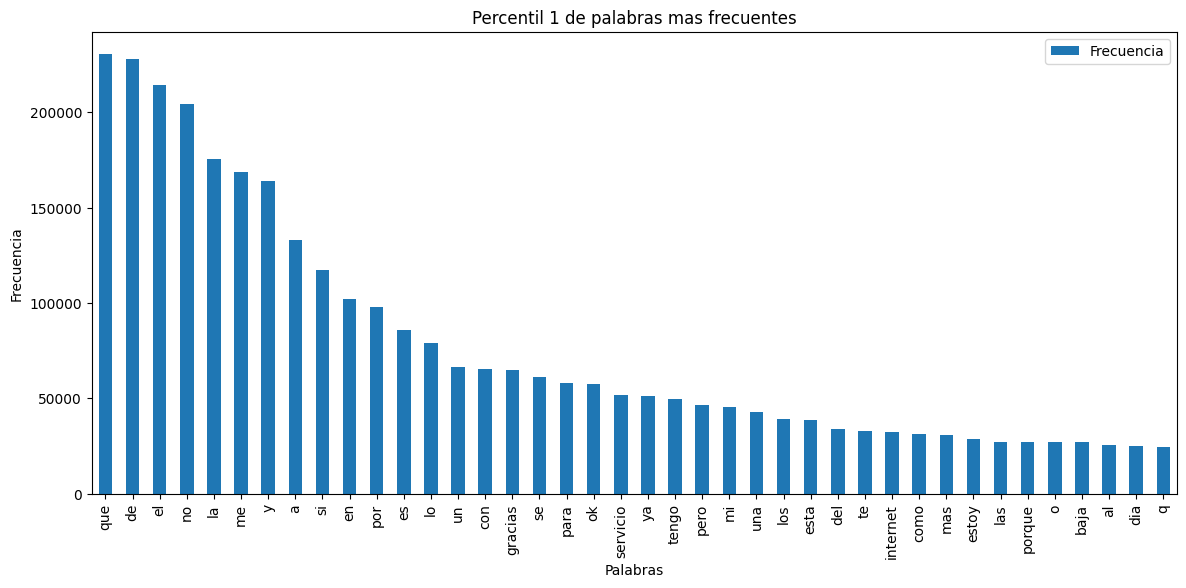

In [ ]:
pd.DataFrame(top_1_percentile[:40], columns=['Palabras','Frecuencia']).set_index('Palabras').plot(kind='bar')
plt.title('Percentil 1 de palabras mas frecuentes')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')

In [ ]:
bottom_1_percentile = Counter(tokens).most_common()[-one_percentile:]
print('Palabras menos frecuentes: ')
bottom_1_percentile[:40]

Palabras menos frecuentes: 


[('redpsi', 1),
 ('calilegya', 1),
 ('llamenmen', 1),
 ('adaipro', 1),
 ('ekovinilosgmail', 1),
 ('aumentarem', 1),
 ('enxendido', 1),
 ('serviciosi', 1),
 ('contactactandome', 1),
 ('unes', 1),
 ('disfrazo', 1),
 ('abjo', 1),
 ('ciomo', 1),
 ('lamentablemnente', 1),
 ('solucuion', 1),
 ('bunoe', 1),
 ('holanexcequiel', 1),
 ('pingamelo', 1),
 ('estrimear', 1),
 ('porpio', 1),
 ('estriming', 1),
 ('amigoooooooooooooooooo', 1),
 ('ahite', 1),
 ('sacada', 1),
 ('paraaaa', 1),
 ('segudo', 1),
 ('disgregacion', 1),
 ('gontwstaron', 1),
 ('comprobac', 1),
 ('dectu', 1),
 ('posterguen', 1),
 ('gutiertez', 1),
 ('ntinuar', 1),
 ('nachop', 1),
 ('bjorn', 1),
 ('contestase', 1),
 ('gragiassss', 1),
 ('zoo', 1),
 ('mproblema', 1),
 ('desxde', 1)]

Las stopwords y las palabras de alta/baja frecuencia ahora se han agregado a noise_words, que se eliminarán de las revisiones antes de entrenar los modelos de aprendizaje automático.

Es poco probable que las stopwords sean tan útiles, ya que esperamos que aparezcan con la misma frecuencia en las críticas positivas y negativas. Las palabras poco comunes pueden ser más significativas y, en teoría, podrían indicar el sentimiento de la revisión

In [ ]:
noise_words.extend([word for word,val in top_1_percentile])
noise_words.extend([word for word,val in bottom_1_percentile])

In [ ]:
%%time
def stopwords_removal(stop_words, sentence):
    return [word for word in nltk.word_tokenize(sentence) if word not in stop_words]

df['user_text_nonstop'] = df['user_message_new'].apply(lambda row: stopwords_removal(noise_words, row))
df[['user_message','user_text_nonstop']]

CPU times: user 1min 11s, sys: 334 ms, total: 1min 12s
Wall time: 1min 18s


,user_message,user_text_nonstop
0,"Hola\n***\n***\nBuenos días, Jorgelina\nEstoy ...","[jorgelina, experimentando, lenta, pasando, di..."
1,Buenas tardes\n***\n***\nBuenas tardes\nNecesi...,"[suspender, inquilinos, dejarlos, varia, refie..."
2,Hola Agustina\nEse es viejo..... Pedí que lo c...,"[viejo, cambien, utilizo, accedi, pide, activa..."
3,Hola\nMónica Loru\n***\nAv corrientes ***\nNin...,"[monica, loru, corrientes, monica, camisay, co..."
4,"Hola, por algun motivo internet se desconecta ...","[desconecta, smart, demas, configuracion, rein..."
...,...,...
83295,hola\nJimena Gotelli\n***\nbauness *** ***to d...,"[jimena, bauness, to, villa, urquiza]"
83296,hola\nCaceres Leonardo\n***\nDean Funes ***\nh...,"[caceres, leonardo, dean, funes, leonardo, cac..."
83297,"Hola\n***\nNo, es otra cosa\nNecesitaría ya qu...","[apague, prendo, sucediendo, release, microsof..."
83298,Hola\nYadira Quinche\n***\nLaprida ***\nQuedar...,"[yadira, laprida, quedaron, ambiente]"


En este punto, luego de la remoción de stopwords, vale la pena volver a hacer una limpieza de registros vacíos a partir de la apicación de este proceso

In [ ]:
# Elimimación de registro sin contenido.
df = df[(df['user_text_nonstop'].notna()) & (df['user_text_nonstop'] != '')]
df.reset_index(drop=True, inplace=True)

### Stemming & lemmatization

Ahora estamos listos para la última parte de nuestro preprocesamiento: **stemming & lemmatization.**

Las diferentes formas de una palabra suelen comunicar esencialmente el mismo significado. Por ejemplo, probablemente no haya diferencia de intención entre buscar "zapato" y "zapatos". La misma palabra también puede aparecer en diferentes tiempos verbales; por ejemplo, "correr", "corrió" y "corriendo". Estas diferencias sintácticas entre las formas de las palabras se denominan flexiones. En general, probablemente queramos tratar las flexiones de forma idéntica al extraer características del texto.

**Stemming** funciona eliminando el final o el principio de la palabra, teniendo en cuenta una lista de prefijos y sufijos comunes.

La **lematización** considera el análisis morfológico de las palabras. Por lo tanto, considera la gramática de la palabra e intenta encontrar la raíz en lugar de simplemente llegar a ella mediante métodos de fuerza bruta.

In [ ]:
from nltk.stem import PorterStemmer, LancasterStemmer # Common stemmers
from nltk.stem import WordNetLemmatizer # Common Lematizer
nltk.download('wordnet')
from nltk.corpus import wordnet

porter = PorterStemmer()
lancaster = LancasterStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
%%time
def stemm_terms(row):
    return [lancaster.stem(term) for term in row]
def lemmatize_terms(row):
    return [lemmatizer.lemmatize(term) for term in row]

df['user_text_stemm'] = df['user_text_nonstop'].apply(lambda row: stemm_terms(row))
df['user_text_lemm'] = df['user_text_nonstop'].apply(lambda row: lemmatize_terms(row))
df[['user_text_nonstop','user_text_stemm','user_text_lemm']]

CPU times: user 21.6 s, sys: 297 ms, total: 21.9 s
Wall time: 24 s


,user_text_nonstop,user_text_stemm,user_text_lemm
0,"[jorgelina, experimentando, lenta, pasando, di...","[jorgelin, experimentando, lent, pasando, dif,...","[jorgelina, experimentando, lenta, pasando, di..."
1,"[suspender, inquilinos, dejarlos, varia, refie...","[suspend, inquilino, dejarlo, var, refiero, ha...","[suspender, inquilinos, dejarlos, varia, refie..."
2,"[viejo, cambien, utilizo, accedi, pide, activa...","[viejo, camby, utilizo, acced, pid, activarlo]","[viejo, cambien, utilizo, accedi, pide, activa..."
3,"[monica, loru, corrientes, monica, camisay, co...","[monic, loru, corry, monic, camisay, corry, de...","[monica, loru, corrientes, monica, camisay, co..."
4,"[desconecta, smart, demas, configuracion, rein...","[desconect, smart, dema, configurac, reiniciar...","[desconecta, smart, demas, configuracion, rein..."
...,...,...,...
83295,"[jimena, bauness, to, villa, urquiza]","[jimen, bau, to, vill, urquiz]","[jimena, bauness, to, villa, urquiza]"
83296,"[caceres, leonardo, dean, funes, leonardo, cac...","[cac, leonardo, dean, fun, leonardo, cac, dean...","[caceres, leonardo, dean, funes, leonardo, cac..."
83297,"[apague, prendo, sucediendo, release, microsof...","[apagu, prendo, sucediendo, releas, microsoft,...","[apague, prendo, sucediendo, release, microsof..."
83298,"[yadira, laprida, quedaron, ambiente]","[yadir, laprid, quedaron, amby]","[yadira, laprida, quedaron, ambiente]"


Volvamos a ver cómo ha mutado la nube de palabras en los mensajes de usuario después de estos procesos.

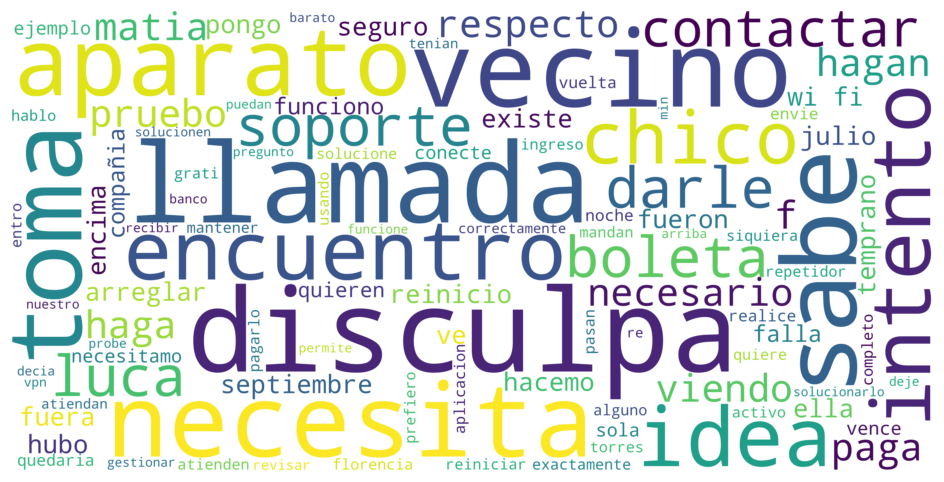

CPU times: user 13.1 s, sys: 1.08 s, total: 14.2 s
Wall time: 16 s


In [ ]:
%%time
#Nube de palabras de textos lematizados + NER:
word_cloud_text = ' '.join([' '.join(review) for review in df['user_text_lemm']])
# Primero, une las palabras dentro de cada reseña en una cadena usando ' '.join(review).
# Después une todas las reseñas en una sola cadena usando ' '.join(...).

wordcloud = WordCloud(max_font_size=100, # Maximum font size for the largest word
                      max_words=100, # The maximum number of words
                      background_color="white", # Background color for the word cloud image
                      scale = 10, # Scaling between computation and drawing
                      width=800, # Width of the canvas
                      height=400 # Height of the canvas
                     ).generate(word_cloud_text)

plt.figure()
plt.imshow(wordcloud,
           interpolation="bilinear") # to make the displayed image appear more smoothly
plt.axis("off")
plt.show()

# Machine learning model


In [ ]:
# Modeling packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

### Bag-of-words

El procedimiento de **bolsa de palabras** se enmarca en una categoría más amplia de técnicas conocidas como representaciones basadas en conteo. Estas técnicas permiten analizar documentos indicando la frecuencia con la que aparecen ciertos tipos de estructuras.

Comencemos con los 1-gramas (palabras). El tipo de información más simple sería si una palabra en particular aparece en documentos específicos. Esto genera matrices de coocurrencia de palabra-documento, donde la entrada de la matriz de palabra-documento se establece en 1 si la palabra
aparece en el documento
, y en 0 en caso contrario.

Creemos una matriz de coocurrencia de palabra-documento para nuestro conjunto de revisiones utilizando la clase CountVectorizer, que considera automáticamente ciertos pasos de preprocesamiento, como la eliminación de palabras vacías, la lematización, la creación de n-gramas y la tokenización de palabras.

Usemos esto para crear una bolsa de palabras a partir de los mensajes, excluyendo las palabras irrelevantes que identificamos anteriormente:

In [ ]:
# El siguiente código crea una matriz de de las palabra en el dataframe.
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
# Join the lemmatized tokens back into a single string for each document
df['user_text_lemm_str'] = df['user_text_lemm'].apply(' '.join)
X = vec.fit_transform(df['user_text_lemm_str']) # Use the new string column
## X = vec.fit_transform(df['user_text_lemm'])

In [ ]:
# Cree un nuevo DataFrame para la matriz de palabras para evitar sobrescribir el df original
bow_df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names_out())
bow_df.head()

,aa,aaa,aaaa,aaaaa,aaaaaa,aaaaaaa,aaaaaaaa,aaaaaaaaa,aaaaaaaaaa,aaaaaaaaaaa,...,ñroxe,ñsi,ñsos,ñucas,ñuede,ñuego,ñujo,ñvlbaad,ñwifi,ññ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
### Creando un objeto de Python de la clase CountVectorizer

bow_counts = CountVectorizer(tokenizer=word_tokenize,  # tipo de tokenización
                             stop_words=noise_words,  # lista de stopwords
                             ngram_range=(1, 1))  # cant de n-grams

# Utilice el df original para crear la representación de bolsa de palabras
bow_data = bow_counts.fit_transform(df['user_message_new'])

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
bow_data

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 980355 stored elements and shape (83300, 77266)>

Podemos observar que se ha construido una matriz dispersa de 937773 observaciones  en 83300 filas (número de filas de la serie `user_message_new`) y 68572 columnas correspondientes a las características extraídas mediante la representación del recuento de 1 gramo de las reseñas de los usuarios.

Una vez preparada la bolsa de palabras, el conjunto de datos debe dividirse en conjuntos de entrenamiento y de prueba:

In [ ]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(bow_data, # Features
                                                                    df['Sentiment_rating'], # Target variable
                                                                    test_size = 0.2, # 20% test size
                                                                    random_state = 0) # random state for replication purposes

In [ ]:
y_test_bow.value_counts()/y_test_bow.shape[0]

,count
Sentiment_rating,
0,0.508643
1,0.491357


Los datos de prueba contienen un 49 % de reseñas positivas. Por lo tanto, si clasificáramos todas las reseñas como positivas, nuestro modelo alcanzaría una precisión del 49 %. Por lo tanto, este es el punto de referencia que cualquier modelo que creemos debe superar.

#### Applying logistic regression to Bag-of-Words

Entrenemos el modelo con nuestros datos de entrenamiento y ejecutemos el modelo resultante en nuestros datos de prueba:

In [ ]:

### Training the model
lr_model_all = LogisticRegression() # Logistic regression
lr_model_all.fit(X_train_bow, y_train_bow) # Fitting a logistic regression model

## Predicting the output
test_pred_lr_all = lr_model_all.predict(X_test_bow) # Class prediction

## Calculate key performance metrics
print("F1 score: ", f1_score(y_test_bow, test_pred_lr_all))

F1 score:  0.6775692013999364


Obtuvimos un rendimiento del 68%. No es malo pero intentaremos mejorarlo.

Modifiquemos el conjunto de características del modelo para incluir bigramas, trigramas y 4-gramas:

In [ ]:
### Changes with respect to the previous code
### 1. Increasing the n-grams from just having 1-gram to (1-gram, 2-gram, 3-gram, and 4-gram)
### 2. Including the stopwords in the bag of words features

bow_counts = CountVectorizer(tokenizer= word_tokenize,
                             ngram_range=(1,4))

bow_data = bow_counts.fit_transform(df.user_message_new)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
# Observe el aumento de características con la inclusión de n-gramas
bow_data

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 23910860 stored elements and shape (83300, 8950415)>

In [ ]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(bow_data,
                                                                    df['Sentiment_rating'],
                                                                    test_size = 0.2,
                                                                    random_state = 0)

In [ ]:
%%time
# Defining and training the model
lr_model_all_new = LogisticRegression(max_iter = 200)
# Fitteo
lr_model_all_new.fit(X_train_bow, y_train_bow)

# Predicting the results
test_pred_lr_all = lr_model_all_new.predict(X_test_bow)

print("F1 score: ", f1_score(y_test_bow,test_pred_lr_all))

F1 score:  0.8204807992507025
CPU times: user 7min 21s, sys: 1min 11s, total: 8min 32s
Wall time: 7min


La puntuación F1 ha aumentado en un 15%. Este es un ejemplo de cómo un simple ajuste de hiperparámetros y la modificación de las características de entrada pueden influir en el rendimiento general.
Incluso podemos obtener características interpretables a partir de esto, en términos de qué contribuyó más al sentimiento positivo y negativo:

In [ ]:
lr_weights = pd.DataFrame(list(zip(bow_counts.get_feature_names_out(), # ge tall the n-gram feature names
                                   lr_model_all_new.coef_[0])), # get the logistic regression coefficients
                          columns= ['words','weights']) # defining the colunm names

print("Top #15 características más importantes para obtener reseñas POSITIVAS:")
lr_weights.sort_values(['weights'], ascending = False)[:15] # top-15 more important features for positive reviews

Top #15 características más importantes para obtener reseñas POSITIVAS:


,words,weights
3439140,gracias,1.726117
5079309,mil gracias,1.472698
6056734,perfecto,1.423030
3157098,excelente,1.320629
241923,agradezco,1.257045
5255918,nada mas,1.238856
2829979,es todo,1.212725
1310413,confirmo,1.197841
3401235,genial,1.197831
811182,buenisimo,1.168324


In [ ]:
print("Top #15 características más importantes para obtener reseñas NEGATIVAS::")
lr_weights.sort_values(['weights'], ascending = False)[-15:] # top-15 more important features for negative reviews

Top #15 características más importantes para obtener reseñas NEGATIVAS::


,words,weights
3859641,imposible,-0.711520
5433356,no me sirve,-0.740770
3467074,gracias ok gracias,-0.764156
3820979,humano,-0.775124
366332,alguien,-0.780317
2920233,esperando,-0.782981
6146302,pesimo,-0.823379
3775925,horas,-0.862234
3453643,gracias gracias,-0.879554
1998459,desastre,-0.900146


### TF-IDF model

Las **bolsas de palabras** no son la única forma de caracterizar texto. Otro método es el de Frecuencia de **Término-Frecuencia Inversa de Documento (TF-IDF)**. Este evalúa la importancia de una palabra para un documento dentro de un amplio conjunto de documentos (es decir, un corpus). La importancia aumenta proporcionalmente según el número de veces que aparece una palabra en el documento, pero se compensa con su frecuencia en el corpus.

La ponderación TF-IDF es el producto de dos términos. El primero calcula la Frecuencia de Término (TF) normalizada; es decir, el número de veces que aparece una palabra en un documento dividido entre el número total de palabras de ese documento. El segundo término es la Frecuencia Inversa de Documento (IDF), calculada como el logaritmo del número de documentos del corpus dividido entre el número de documentos donde aparece el término específico.

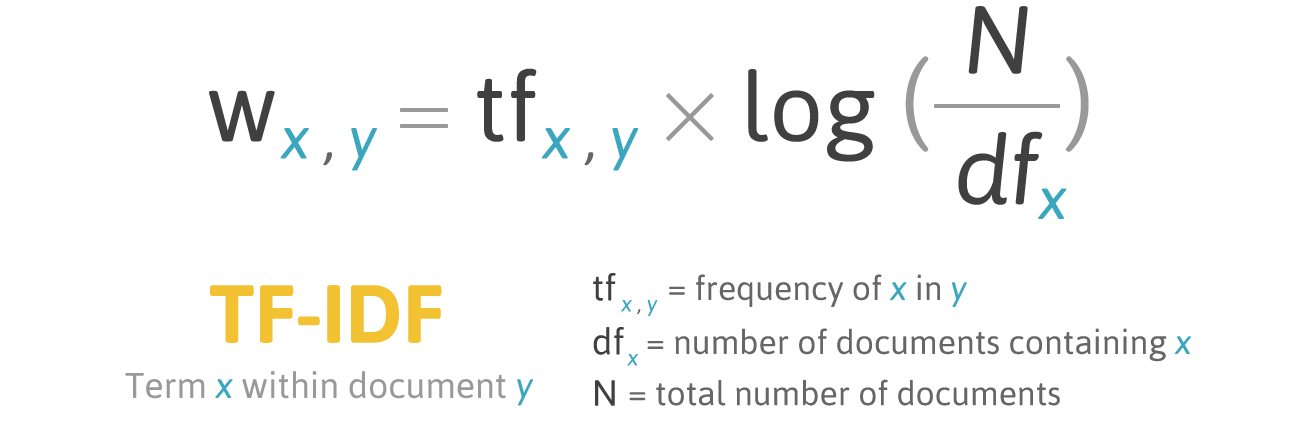

Renovaremos nuestro conjunto original de revisiones basadas en TF-IDF y dividiremos las características resultantes en conjuntos de prueba y entrenamiento:

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

### Creando un objeto de Python de la clase TF-IDF
tfidf_counts = TfidfVectorizer(tokenizer= word_tokenize, # tipo de tokenización
                               stop_words=noise_words, # lista de stopwords
                               ngram_range=(1,1)) # cant de n-grams

# tfidf_data = tfidf_counts.fit_transform(df['user_text_lemm'])
df['user_text_lemm_str'] = df['user_text_lemm'].apply(' '.join)
# Apply fit_transform on this new column
tfidf_data = tfidf_counts.fit_transform(df['user_text_lemm_str'])

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
tfidf_data

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 974350 stored elements and shape (83300, 76561)>

In [ ]:
%%time
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tfidf_data,
                                                                            df['Sentiment_rating'],
                                                                            test_size = 0.2,
                                                                            random_state = 0)

CPU times: user 15.7 ms, sys: 2.07 ms, total: 17.8 ms
Wall time: 17.3 ms


#### Applying logistic regression to TF-IDF features

Apliquemos la regresión logística a las características creadas a partir de TF-IDF:

In [ ]:
%%time
### Instanciar modelo
lr_model_tf_idf = LogisticRegression()

## Entrenar modelo
lr_model_tf_idf.fit(X_train_tfidf,y_train_tfidf)

## Predecir resultados
test_pred_lr_all = lr_model_tf_idf.predict(X_test_tfidf)

## Evaluar modelo
print("F1 score: ",f1_score(y_test_tfidf, test_pred_lr_all))

F1 score:  0.6992139523458609
CPU times: user 674 ms, sys: 357 ms, total: 1.03 s
Wall time: 580 ms


Aquí hemos disminuido ligeramente nuestro valor de puntuación F1 con TF-IDF en comparación con el enfoque de bolsa de palabras.

### Word embeddings model

El último tipo de caracterización que abordaremos son las **word embeddings ** (incrustaciones de palabras). Se trata de un tipo de representación de palabras que permite que palabras con significados similares tengan una representación similar. Este enfoque para representar palabras y documentos puede considerarse uno de los avances clave del aprendizaje profundo en la resolución de problemas complejos de procesamiento del lenguaje natural. Permite capturar el contexto de una palabra en un documento, su similitud semántica y sintáctica, y su relación con otras palabras. Las incrustaciones de palabras son, de hecho, un tipo de técnicas en las que las palabras individuales se representan como vectores de valor real en un espacio vectorial predefinido. Esta sería una representación gráfica:

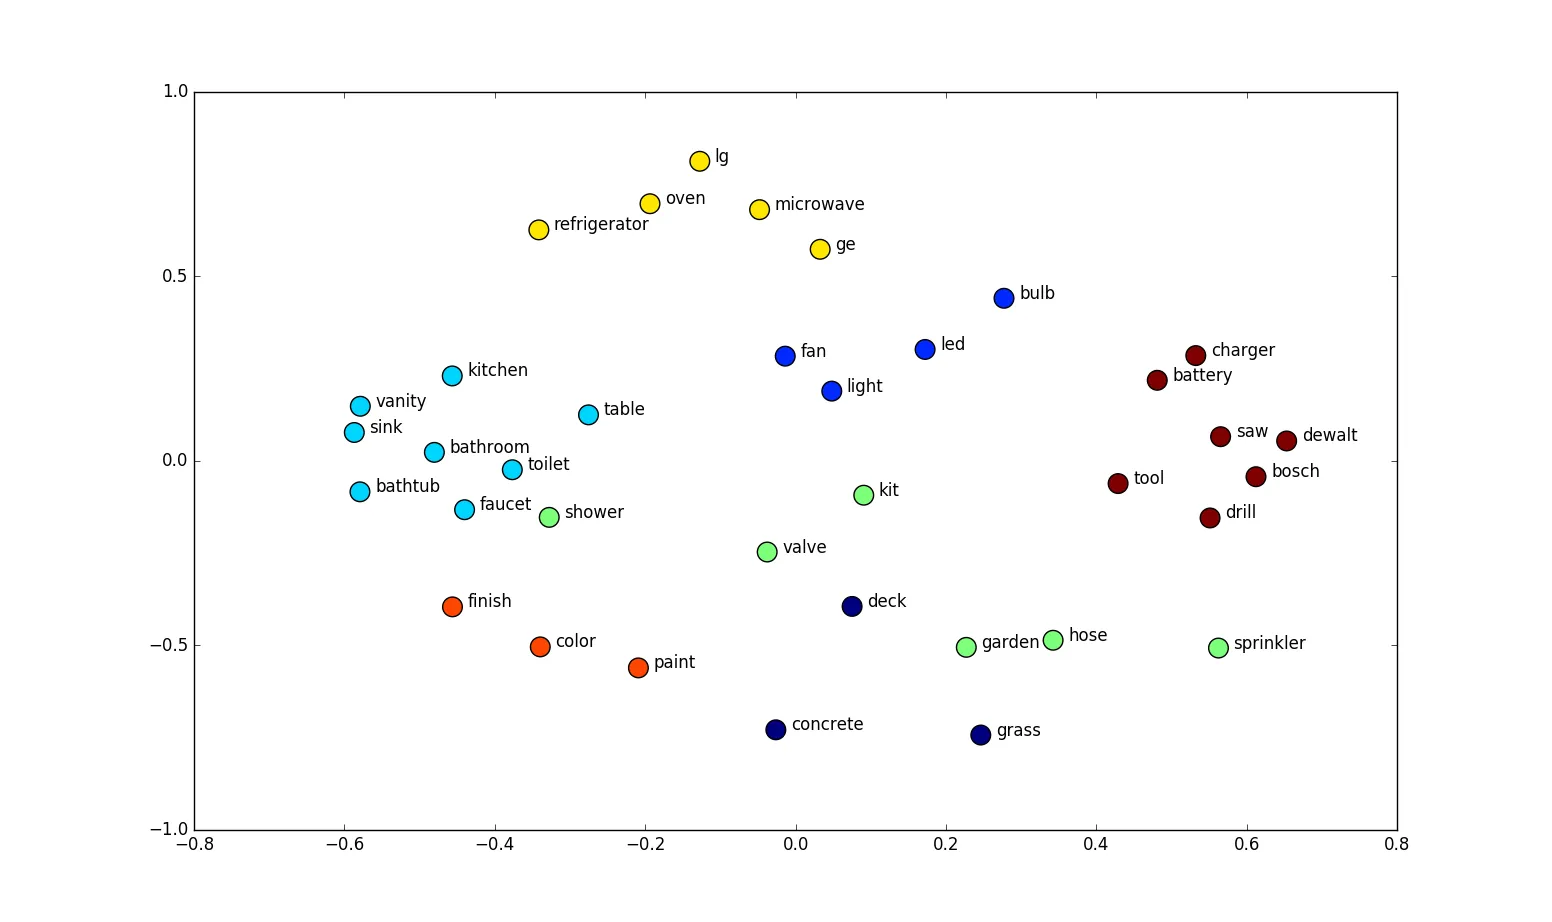

En esta imagen, cada palabra se ha representado en dos dimensiones para simplificar. Se puede observar claramente que las palabras con contexto similar están agrupadas: baño, cocina y bañera se agrupan juntas, mientras que microondas, refrigerador y horno forman otro grupo, etc.

Existen diferentes métodos para aprender incrustaciones de palabras, como Word2Vec, GloVe, FastText, incrustación espectral y UMAP, entre otros:


*   **Word2Vec**: utiliza una Red Neuronal superficial.
*   **GloVe**: es un algoritmo de aprendizaje no supervisado para obtener representaciones vectoriales de palabras. El entrenamiento se realiza con estadísticas globales agregadas de coocurrencia palabra-palabra de un corpus, y las representaciones resultantes muestran interesantes subestructuras lineales del espacio vectorial de palabras.
*   **FastText**: es una biblioteca para el aprendizaje de incrustaciones de palabras y la clasificación de textos creada por el laboratorio de investigación de IA de Facebook.
*   **Spectral embedding**: es una técnica de reducción de dimensionalidad que forma una matriz de afinidad aplicando una descomposición espectral.
*   **UMAP**: la Aproximación y Proyección de Variedad Uniforme es una técnica de reducción de dimensionalidad utilizada para procedimientos generales de reducción de dimensionalidad no lineal.

#### ¿Por qué usar incrustaciones de palabras en lugar de bolsas de palabras y TF-IDF?


Cada palabra se representa mediante un vector de valor real, que generalmente tiene decenas o cientos de dimensiones. Esto contrasta con los miles o millones de dimensiones que requieren las representaciones de palabras dispersas. Por lo tanto, las incrustaciones de palabras pueden reducir drásticamente el número de dimensiones necesarias para representar un documento de texto:

In [ ]:
!pip install --upgrade gensim
import gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 19.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


In [ ]:
import os

### Loading a pre-trained glove word embedding that is trained on twitter dataset
### This word embedding is 200 dimensional in lenght (200 features per term)
### Source: https://nlp.stanford.edu/projects/glove/
file_path = os.path.join(os.getcwd(), 'glove.twitter.27B.50d.txt')

# Load the model using gensim's KeyedVectors.load_word2vec_format
# with no_header=True to skip the first line if it's not in the expected format
model = gensim.models.KeyedVectors.load_word2vec_format(
    file_path, binary=False, no_header=True
)

Para hallar el vector de una reseña completa, obtenemos el vector de cada palabra de la reseña por separado y calculamos un promedio simple.

Calculemos el vector de cada reseña del conjunto de datos:

In [ ]:
# List for adding each average representation per observation
review_embeddings = []

## Review_average
Review_average = np.zeros(model.vector_size)

# For each review in the review's dataset
for each_review in df['user_text_lemm']:  # each_review is now a list of tokens

    count_val = 0

    # Iterate directly over tokens in each_review
    for each_word in each_review:  # No need for word_tokenize
        if each_word.lower() in model:
            Review_average += model[each_word.lower()]
            count_val += 1

    # Check if count_val is greater than 0 to avoid ZeroDivisionError
    if count_val > 0:
        review_embeddings.append(list(Review_average / count_val))
    else:
        # Handle the case where count_val is 0 (e.g., append a zero vector)
        review_embeddings.append(list(np.zeros(model.vector_size)))

Convertimos la lista de representaciones vectoriales para cada revisión en un DataFrame y la dividimos en conjuntos de entrenamiento y prueba:

In [ ]:
# Convertir dataframe en objeto
embedding_data = pd.DataFrame(review_embeddings)

# Filling null values
# Los valores nulos son los que el modelo preentrenado de Twitter no considera (algunos de ellos)
embedding_data = embedding_data.fillna(0)
embedding_data

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.028204,0.246429,-0.217723,0.378920,-0.017784,0.191928,-0.155912,-0.197816,-0.111484,-0.611275,...,-0.180155,0.434801,0.186205,-0.007468,0.057293,0.167085,0.173903,0.409650,-0.367178,-0.240655
1,-0.670459,3.118116,-2.564590,4.285620,-0.107512,1.882318,-1.988789,-1.974564,-0.903523,-6.947047,...,-1.576170,4.720461,2.211184,-0.310999,0.877764,2.084893,2.243057,4.588588,-3.937008,-2.924256
2,-1.641849,7.740674,-6.693398,10.944787,-0.240216,4.242430,-4.759590,-4.530727,-2.115979,-17.472270,...,-3.637669,11.488851,5.556509,-0.811021,2.682659,5.002656,5.864445,11.318395,-9.993417,-7.378227
3,-1.487294,5.988696,-4.611615,7.606077,-0.179258,2.822463,-3.649850,-3.307221,-1.557554,-13.138241,...,-2.649020,8.286570,4.353418,-0.609988,1.317355,3.904848,4.334702,8.360591,-7.399284,-5.409431
4,-1.669943,5.286517,-4.499462,6.933848,-0.011733,2.677730,-3.429149,-3.044028,-1.615963,-11.708093,...,-2.540652,7.847262,3.941739,-0.460988,1.117446,3.250307,4.033725,8.008255,-7.111576,-5.219228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83295,-13156.547520,87458.229752,-35513.486615,49661.818444,25809.376750,-28146.525824,-63293.490147,-17493.337088,3642.997771,-156837.716054,...,-69623.328773,47851.965720,53645.481121,6319.665450,8928.473619,6667.978082,37859.645803,98645.211914,-51043.465767,-93962.370909
83296,-5262.816638,34983.247420,-14205.010498,19864.500285,10323.362925,-11259.355374,-25317.665424,-6997.127043,1456.666053,-62735.538926,...,-27849.758046,19140.487556,21458.531012,2528.203619,3571.485235,2667.231920,15143.613966,39458.376959,-20417.354953,-37586.001346
83297,-2192.898822,14576.521597,-5918.887964,8277.244993,4301.521662,-4691.261213,-10549.215365,-2915.598339,607.166215,-26140.467637,...,-11604.414953,7975.500320,8941.188482,1053.414402,1488.173286,1111.648165,6309.848659,16441.391274,-8507.716747,-15661.090208
83298,-13157.478857,87459.505170,-35513.142386,49663.287224,25809.250616,-28147.619954,-63295.820769,-17493.949203,3642.824457,-156843.685551,...,-69626.303166,47853.289282,53647.252703,6320.434834,8928.842822,6669.854825,37859.372974,98648.674398,-51046.369870,-93966.935810


#### Applying logistic regression to TF-IDF

In [ ]:
X_train_embed, X_test_embed, y_train_embed, y_test_embed = train_test_split(embedding_data,
                                                                            df['Sentiment_rating'],
                                                                            test_size = 0.2,
                                                                            random_state = 0)

Apliquemos ahora la regresión logística a nuestra representación de word-embeddings:

In [ ]:
lr_model_all.fit(X_train_embed, y_train_embed)
test_pred_lr_all = lr_model_all.predict(X_test_embed)

print("F1 score: ",f1_score(y_test_embed, test_pred_lr_all))

F1 score:  0.9813973744789398


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Deep Learning


Construimos una Red Neuronal Recurrente (RNN) con el fin de comparar el éxito de los algoritmos anteriores con uno más complejo y analizaremos resultados.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
%%time
# 1. Create TF-IDF features
vectorizer = TfidfVectorizer()
# Join the lemmatized tokens back into a single string for each document
df['user_text_lemm_str'] = df['user_text_lemm'].apply(' '.join)
X = vectorizer.fit_transform(df['user_text_lemm_str']) # Use the new string column

CPU times: user 2.11 s, sys: 65.2 ms, total: 2.18 s
Wall time: 4.41 s


In [ ]:
# 2. Split data en training y testing sets
X_train_embed, X_test_embed, y_train_embed, y_test_embed = train_test_split(
    X, df['Sentiment_rating'], test_size=0.2, random_state=0
)

In [ ]:
# Instanciar el modelo RNN (para que no consuma tanta RAM)
model = Sequential()
model.add(Embedding(input_dim=X_train_embed.shape[1], output_dim=64))
model.add(LSTM(units=32, return_sequences=True))
model.add(LSTM(units=16))
model.add(Dense(units=1, activation='sigmoid'))

In [ ]:
# Compilar el model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Entrenar el modelo
model.fit(X_train_embed, y_train_embed, epochs=10, batch_size=32, validation_split=0.2)

# Evaluar el modelo
loss, accuracy = model.evaluate(X_test_embed, y_test_embed)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Hacer predicciones
predictions = model.predict(X_test_embed)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - accuracy: 0.8620 - loss: 0.6246 - val_accuracy: 0.9524 - val_loss: 0.2848
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 35s 6s/step - accuracy: 0.8727 - loss: 0.3965 - val_accuracy: 0.9524 - val_loss: 0.2014
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 38s 6s/step - accuracy: 0.8526 - loss: 0.4390 - val_accuracy: 0.9524 - val_loss: 0.2194
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 36s 6s/step - accuracy: 0.8635 - loss: 0.4003 - val_accuracy: 0.9524 - val_loss: 0.2390
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step - accuracy: 0.8548 - loss: 0.4164 - val_accuracy: 0.9524 - val_loss: 0.2483
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 39s 6s/step - accuracy: 0.8829 - loss: 0.3680 - val_accuracy: 0.9524 - val_loss: 0.2278
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.8768 - loss: 0.3736 - val_accuracy: 0.9524 - val_loss: 0.2289
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - accuracy: 0.8631 - loss: 0.4001 - val_accuracy: 0.9524 - val_loss: 0.2300
Epoch 9/

# Conclusión
El modelo basado en word embeddings demostró una precisión notable del 98%, superando significativamente las representaciones tradicionales como Bag-of-Words y TF-IDF en la tarea de clasificación. Esta técnica evidenció una gran capacidad para condensar la información semántica del texto en un espacio de menor dimensionalidad.

No obstante, la complejidad inherente de los word embeddings dificulta la interpretabilidad del modelo. La naturaleza distribuida de las representaciones vectoriales dificulta la comprensión directa de qué características específicas contribuyen a las predicciones, lo que limita la capacidad de diagnóstico ante posibles fallos o bajo rendimiento en escenarios particulares.

Por otro lado, la Red Neuronal Recurrente (RNN) alcanzó una precisión del 90%, lo que subraya su potencial para modelar secuencias de texto complejas. Sin embargo, el costo computacional asociado a su entrenamiento y despliegue se considera prohibitivo para las limitaciones de recursos del proyecto.

En contraposición, la estrategia de ingeniería de características mediante Bag-of-Words con 4-gramas arrojó una precisión del 82%. Si bien inferior a los modelos más complejos, esta aproximación ofrece una ventaja crucial: una alta interpretabilidad de las características generadas. La capacidad de comprender directamente la influencia de combinaciones específicas de palabras (n-gramas) en la predicción permite un mejor diagnóstico de los resultados y facilita la identificación de áreas de mejora en los datos o el modelo.

Considerando el equilibrio entre rendimiento, interpretabilidad y eficiencia computacional, la creación de características mediante Bag-of-Words con 4-gramas se establece como la solución más adecuada para este proyecto. Su precisión del 82%, combinada con la transparencia de las características, proporciona una base sólida para el análisis y la iteración, optimizando el uso de los recursos disponibles.